In [1]:
import os
import sys

if os.getcwd().endswith("notebooks"):
    os.chdir("..")

sys.path.append(os.path.abspath("./"))

print(f"Current work directory: {os.getcwd()}")

Current work directory: C:\Users\yyyyx\Work\OC43_machine_learning\Regression_Modeling_of_OC43_Coronavirus_Viral_Burden_from_Host_Single-cell_Transcriptomes_Using_Explainable_Machine_Learning


In [2]:
from pycaret.regression import setup, compare_models, predict_model, finalize_model, save_model, plot_model, create_model,plot_model, pull, interpret_model, get_config,evaluate_model, tune_model
from sklearn.pipeline import Pipeline
import pandas as pd
from catboost import Pool
import matplotlib.pyplot as plt
import numpy as np
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import joblib
import scripts.plotting as pl

In [6]:
train_df = pd.read_csv('./CSV/train_df.csv')

In [7]:
test_df = pd.read_csv('./CSV/test_df.csv')

In [8]:
s = setup(
    data=train_df,
    target='target',
    session_id=42,
    fold=5,
    normalize=False,
    verbose=False,
    train_size=0.8
)

In [6]:
best = compare_models(sort='R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.4508,0.4024,0.6341,0.8701,0.1103,0.0923,27.6400
lightgbm,Light Gradient Boosting Machine,0.4791,0.4469,0.6681,0.8558,0.1149,0.0975,1.8600
gbr,Gradient Boosting Regressor,0.5036,0.4853,0.6961,0.8432,0.1188,0.1017,9.3280
et,Extra Trees Regressor,0.5333,0.5215,0.7219,0.8318,0.1232,0.1090,5.3080
xgboost,Extreme Gradient Boosting,0.5208,0.5334,0.7298,0.8280,0.1243,0.1050,7.2520
rf,Random Forest Regressor,0.5356,0.5423,0.7362,0.8251,0.1250,0.1088,5.9660
br,Bayesian Ridge,0.5752,0.5733,0.7569,0.8149,0.1265,0.1140,0.6620
lar,Least Angle Regression,0.5782,0.5836,0.7635,0.8115,0.1274,0.1148,0.7840
omp,Orthogonal Matching Pursuit,0.6250,0.6672,0.8165,0.7847,0.1351,0.1222,0.6320
ada,AdaBoost Regressor,0.7244,0.7416,0.8609,0.7608,0.1388,0.1380,4.0920


In [7]:
joblib.dump(best,'./Data/model/All_model_compare.pkl')

['./Data/model/All_model_compare.pkl']

In [8]:
best = joblib.load('./Data/model/All_model_compare.pkl')

In [9]:
tuned_cat = tune_model(best)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5175,0.5089,0.7134,0.8394,0.1219,0.1056
1,0.5209,0.5133,0.7165,0.8268,0.1211,0.1045
2,0.5300,0.5252,0.7247,0.8408,0.1263,0.1125
3,0.4857,0.4593,0.6777,0.8539,0.1168,0.1004
4,0.5384,0.5592,0.7478,0.8112,0.1263,0.1077
Mean,0.5185,0.5132,0.7160,0.8344,0.1225,0.1061
Std,0.0180,0.0322,0.0226,0.0144,0.0036,0.0039


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [10]:
final = finalize_model(tuned_cat)

pred = predict_model(final, data=test_df) 
print(pred.head())

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.4348,0.3838,0.6196,0.8749,0.1077,0.0896


     SAMD11      HES4      CPTP     MXRA8     CCNL2    FNDC10      MIB2  \
0 -0.399731  0.756278 -0.547459 -0.124252 -0.749243  1.360358 -0.360550   
1 -0.399731 -1.735103 -0.547459 -0.124252  1.255776 -0.527373  3.034086   
2 -0.399731  1.181935 -0.547459 -0.124252  0.485368 -0.527373 -0.360550   
3 -0.399731  0.824995 -0.547459 -0.124252 -0.749243 -0.527373 -0.360550   
4 -0.399731  0.313046 -0.547459 -0.124252  0.724715 -0.527373 -0.360550   

    MMP23B      HES5  AL139246.5  ...      FLNA  AC244090.1    FAM50A  \
0 -0.18292 -0.075151   -0.225978  ...  2.292584   -0.136126 -1.820006   
1 -0.18292 -0.075151   -0.225978  ... -0.516010   -0.136126 -1.820006   
2 -0.18292 -0.075151   -0.225978  ...  0.890361   -0.136126 -0.014700   
3 -0.18292 -0.075151   -0.225978  ...  1.087655   -0.136126 -0.825432   
4 -0.18292 -0.075151   -0.225978  ... -0.516010   -0.136126 -1.820006   

     PLXNA3      G6PD    FUNDC2    MT-ND5    MT-ND6    target  \
0 -0.203624 -0.501073  1.902857 -0.247492 -0.

In [11]:
joblib.dump(final,'./Data/model/Full_cat.pkl')

['./Data/model/Full_cat.pkl']

In [9]:
best = joblib.load('./Data/model/All_model_compare.pkl')
final = joblib.load('./Data/model/Full_cat.pkl')

In [10]:
pred_holdout_reg = predict_model(final, data=test_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.4348,0.3838,0.6196,0.8749,0.1077,0.0896


(<Figure size 1500x1500 with 1 Axes>,
 <Axes: xlabel='Actual value', ylabel='Predicted value'>)

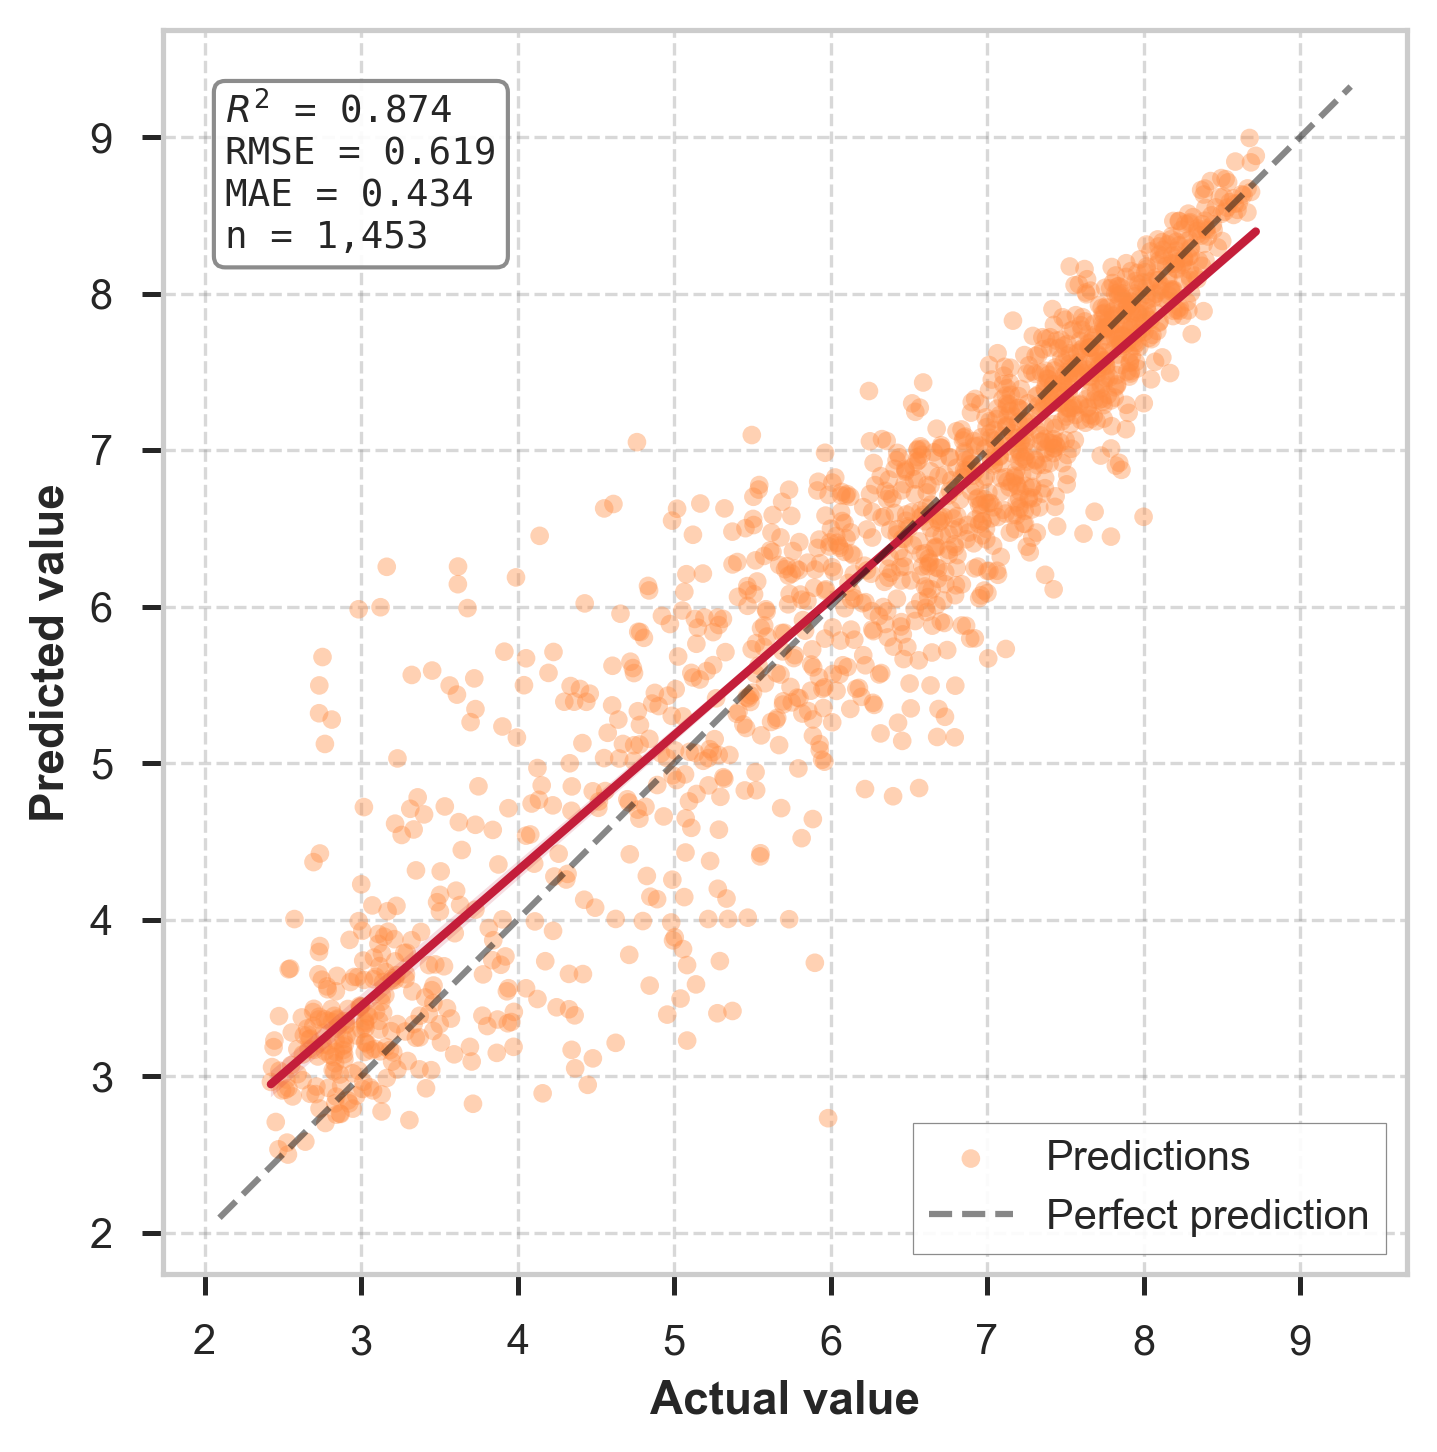

In [11]:
actual = pred_holdout_reg['target']
predicted = pred_holdout_reg['prediction_label']
pl.plot_performance_scatter(y_true=actual, y_pred=predicted,save_path='./Plot/Full_cat.png')

In [12]:
catboost_model = final.steps[-1][1]
preprocessor = Pipeline(final.steps[:-1])

X_raw = train_df.drop(columns=['target'])
y_raw = train_df['target']
feature_names = X_raw.columns.to_list()

X_transformed = preprocessor.transform(X_raw)

if isinstance(X_transformed, pd.DataFrame):
    X_transformed_array = X_transformed.values
else:
    X_transformed_array = X_transformed

X_trans_df = pd.DataFrame(X_transformed, columns=feature_names, index=X_raw.index)

In [13]:
print("🔍 Computing SHAP values...")
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_trans_df)

🔍 Computing SHAP values...


In [14]:
pl.set_publication_style()

Calculating SHAP values...
SHAP beeswarm plot saved to: ./Plot/shap_beeswarm_pub
Feature importance plot saved to: ./Plot/feature_importance_pub


(<Figure size 2400x1500 with 1 Axes>,
 <Axes: title={'center': 'Top 10 Feature Importance'}, xlabel='Feature Importance'>)

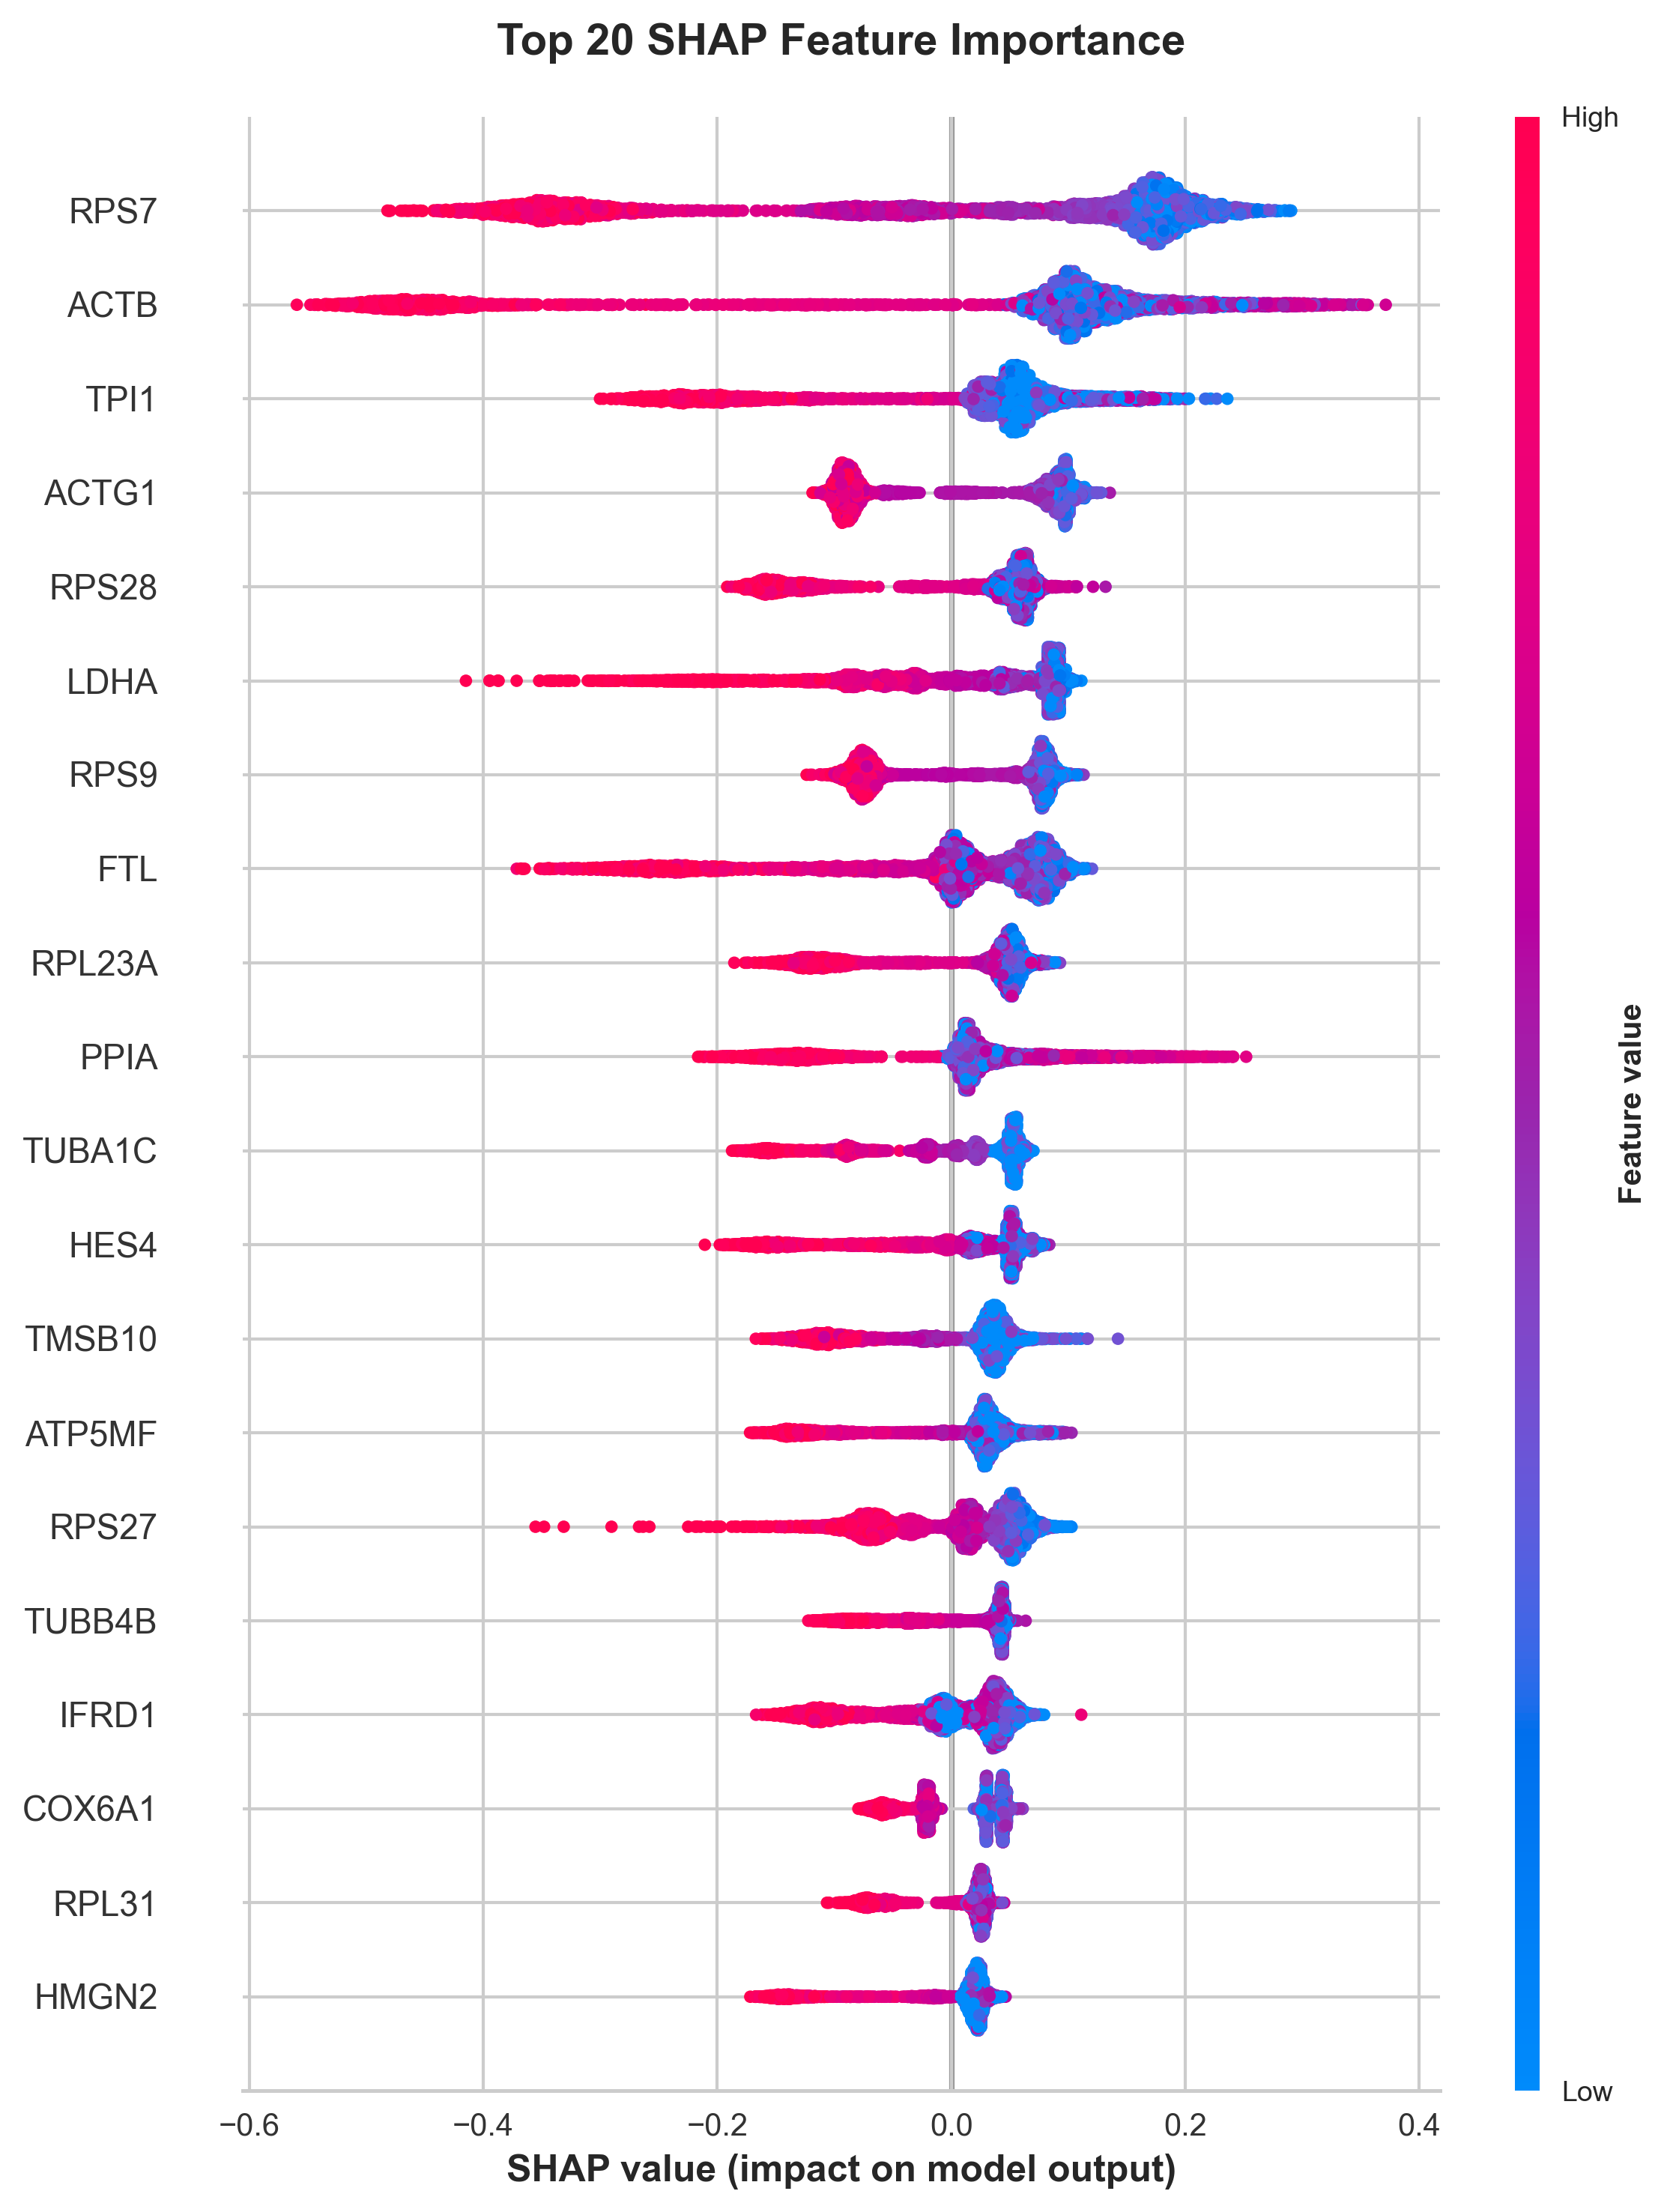

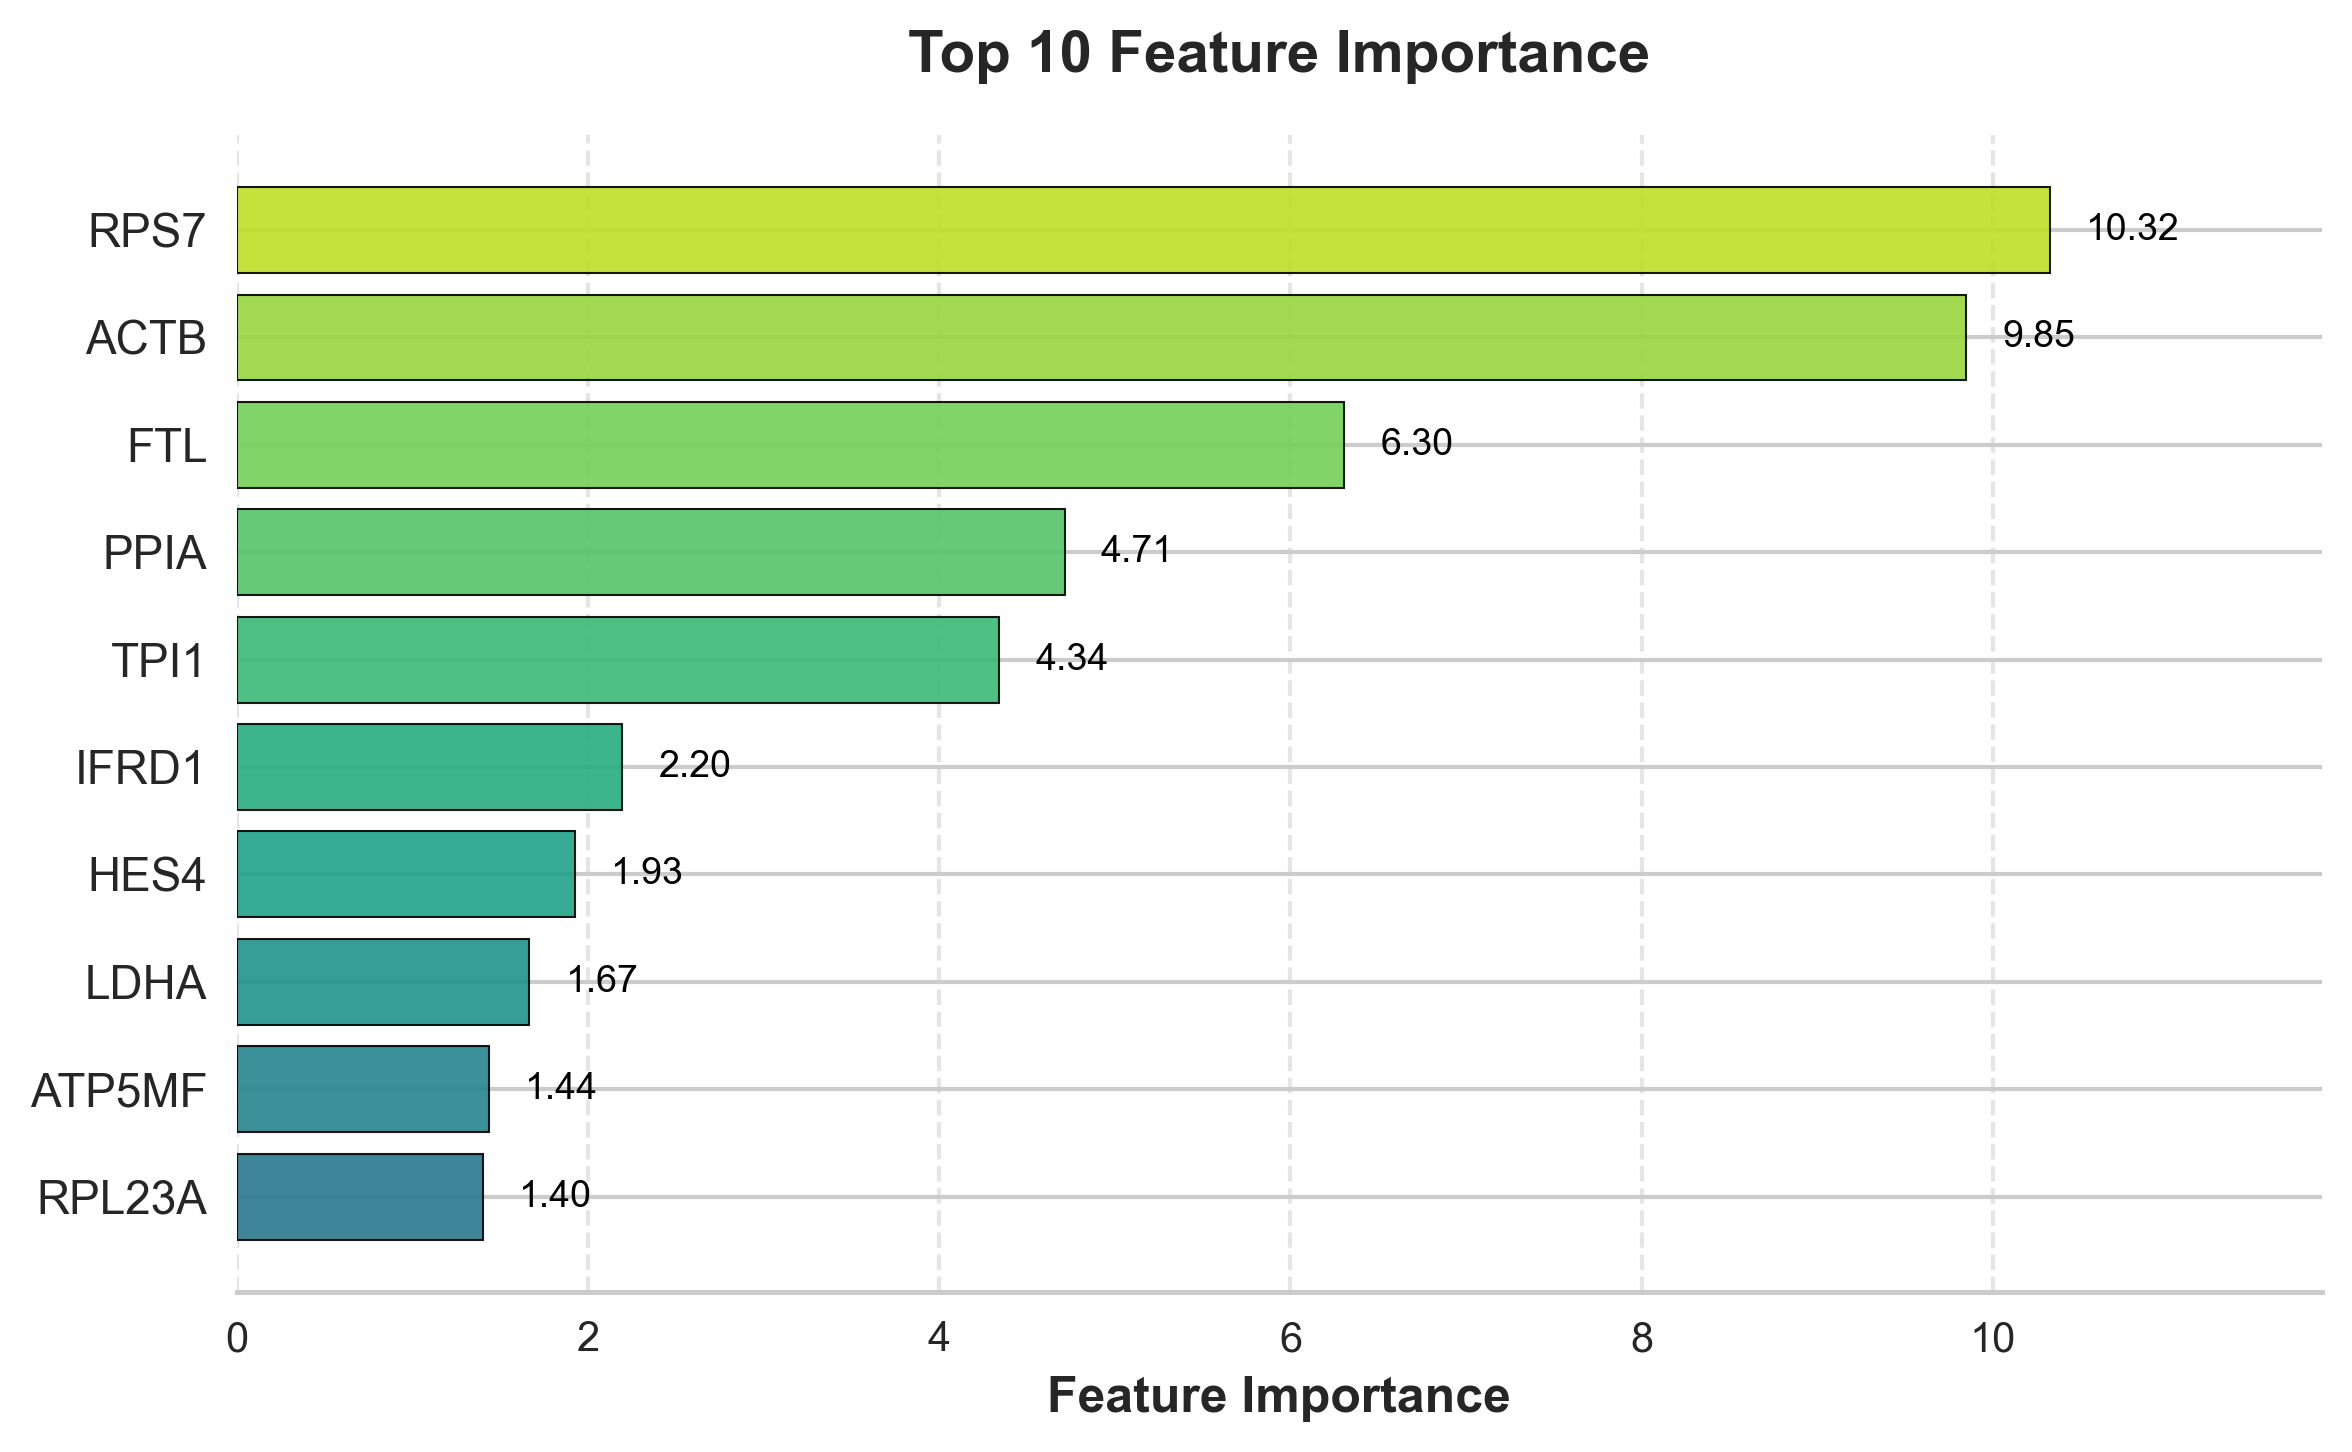

In [15]:
pl.plot_shap_beeswarm(
    model=catboost_model, 
    X_train=X_trans_df, 
    top_k=20, 
    save_path='./Plot/shap_beeswarm_pub'
)

pl.plot_feature_importance(
    model=catboost_model, 
    feature_names=X_trans_df.columns, 
    top_k=10, 
    save_path='./Plot/feature_importance_pub'
)

Custom SHAP plot saved to: ./Plot/Figure1_Panel_D_SHAP


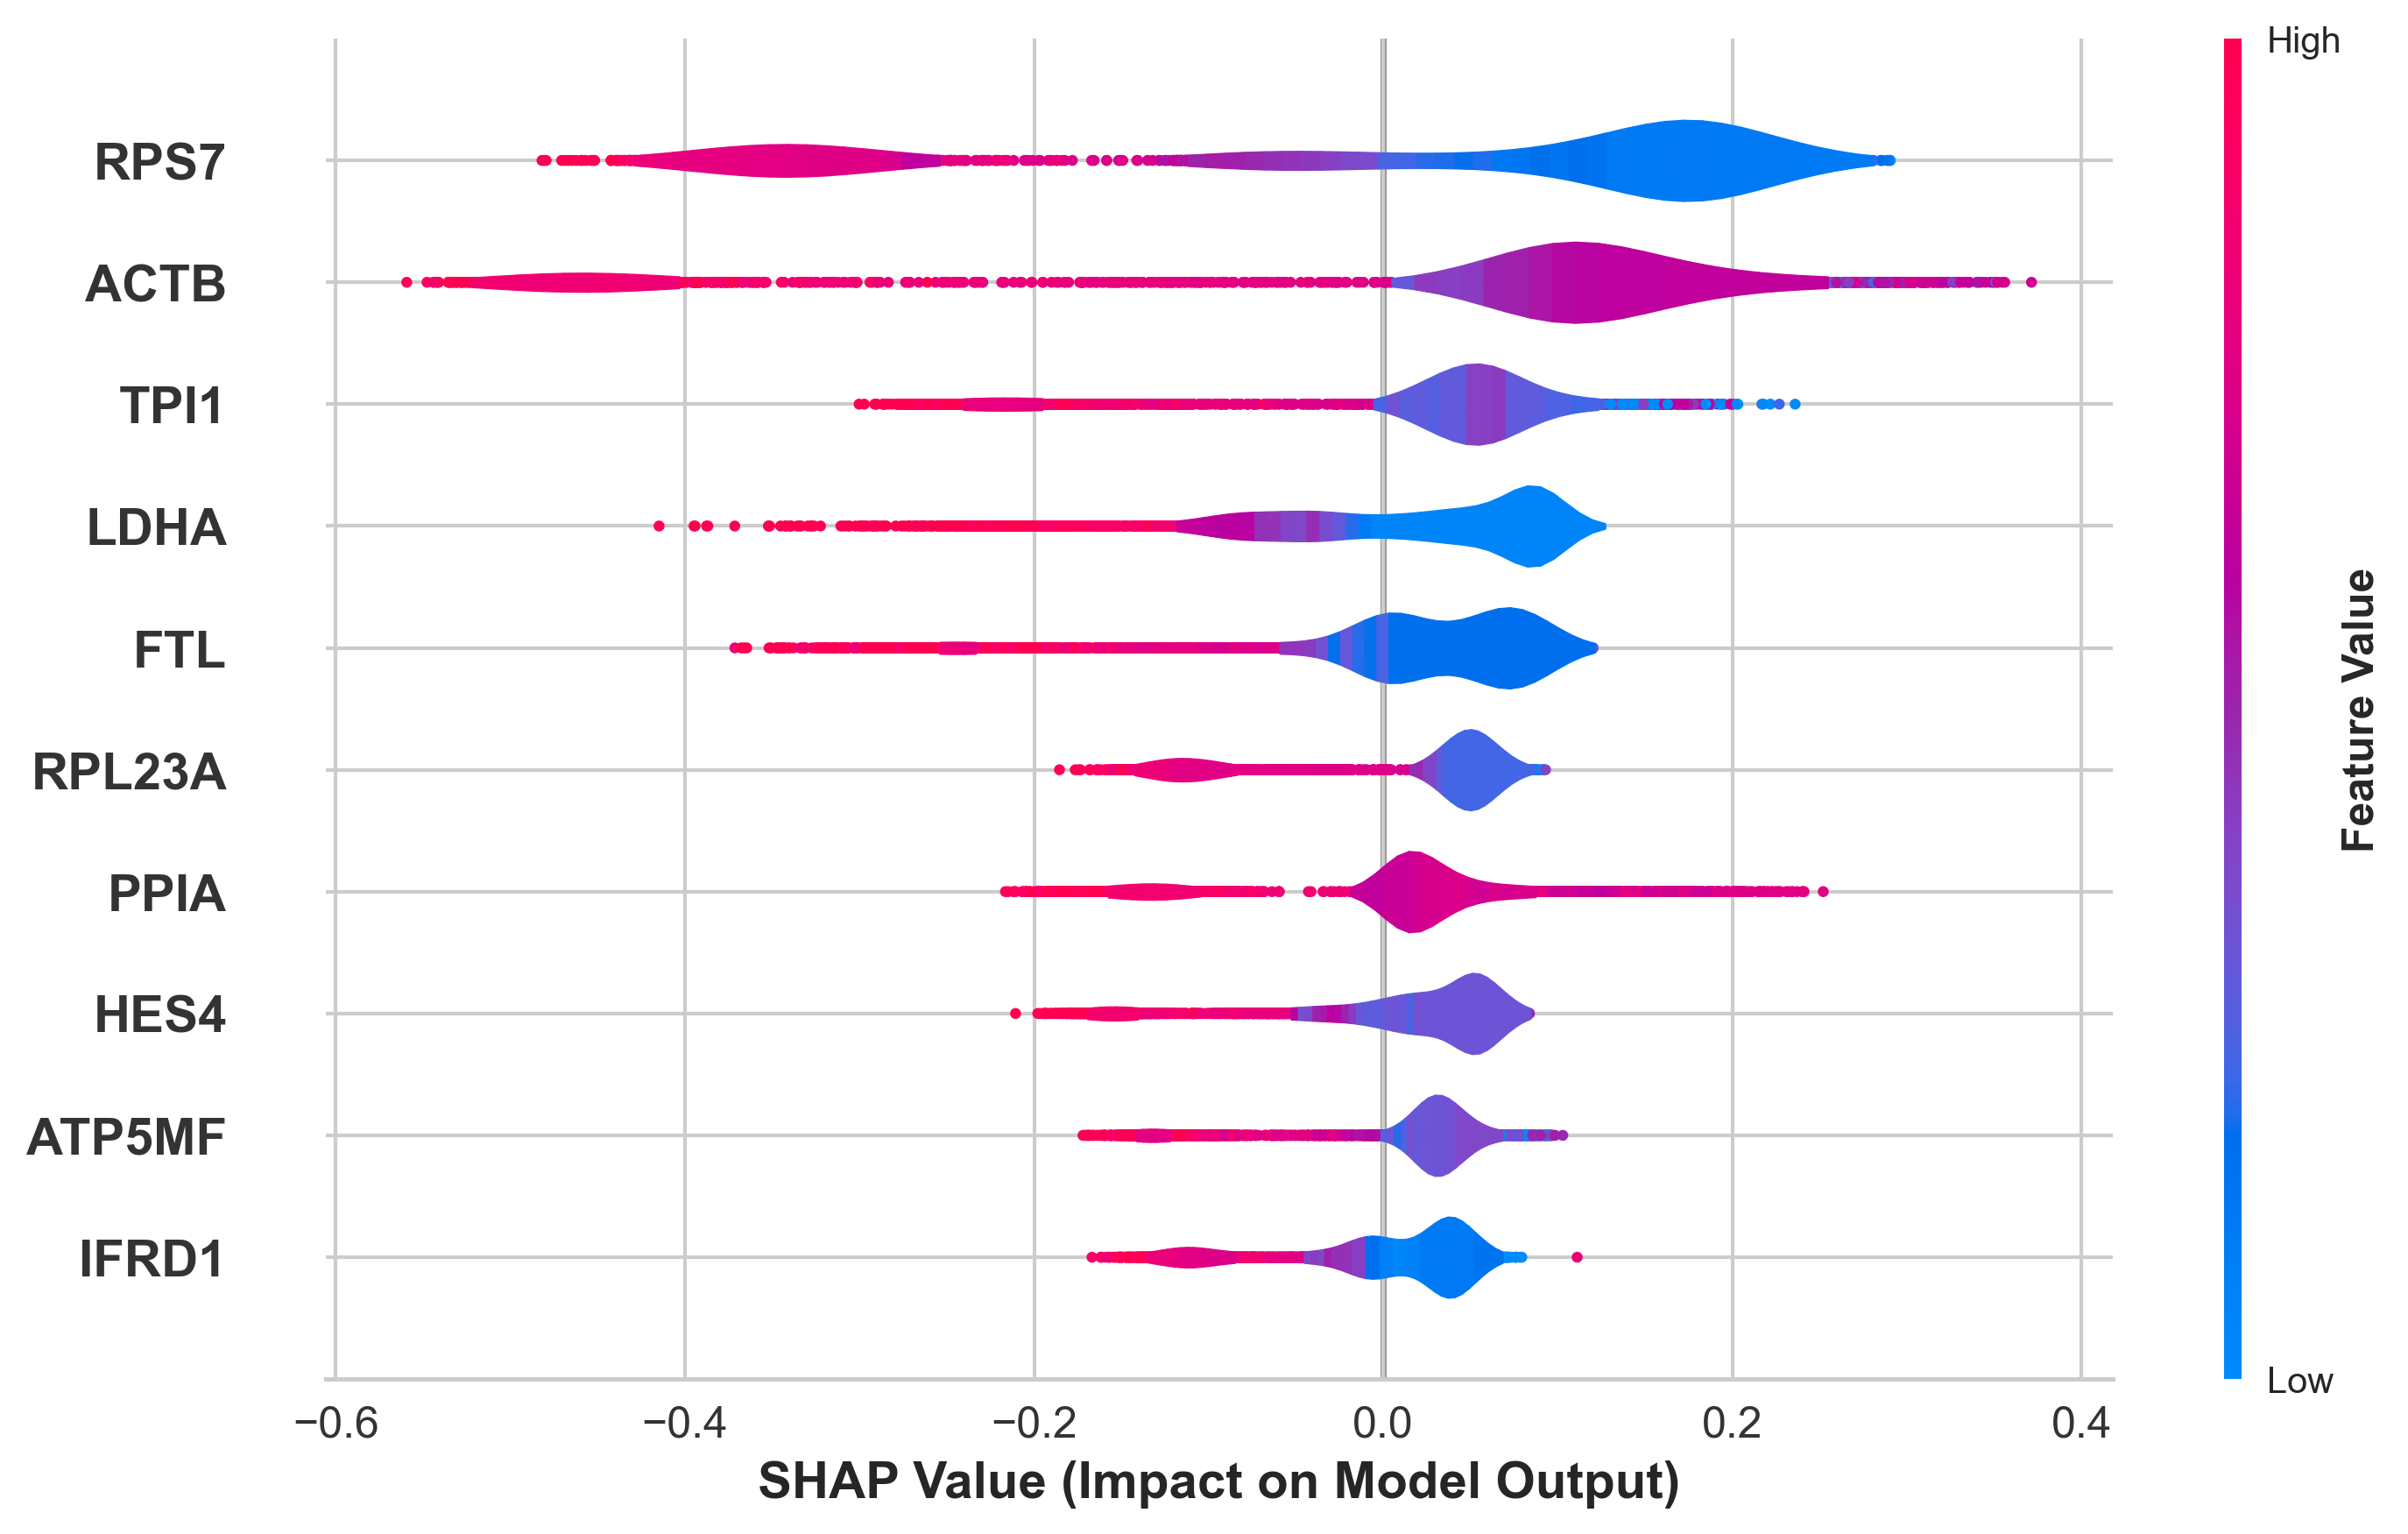

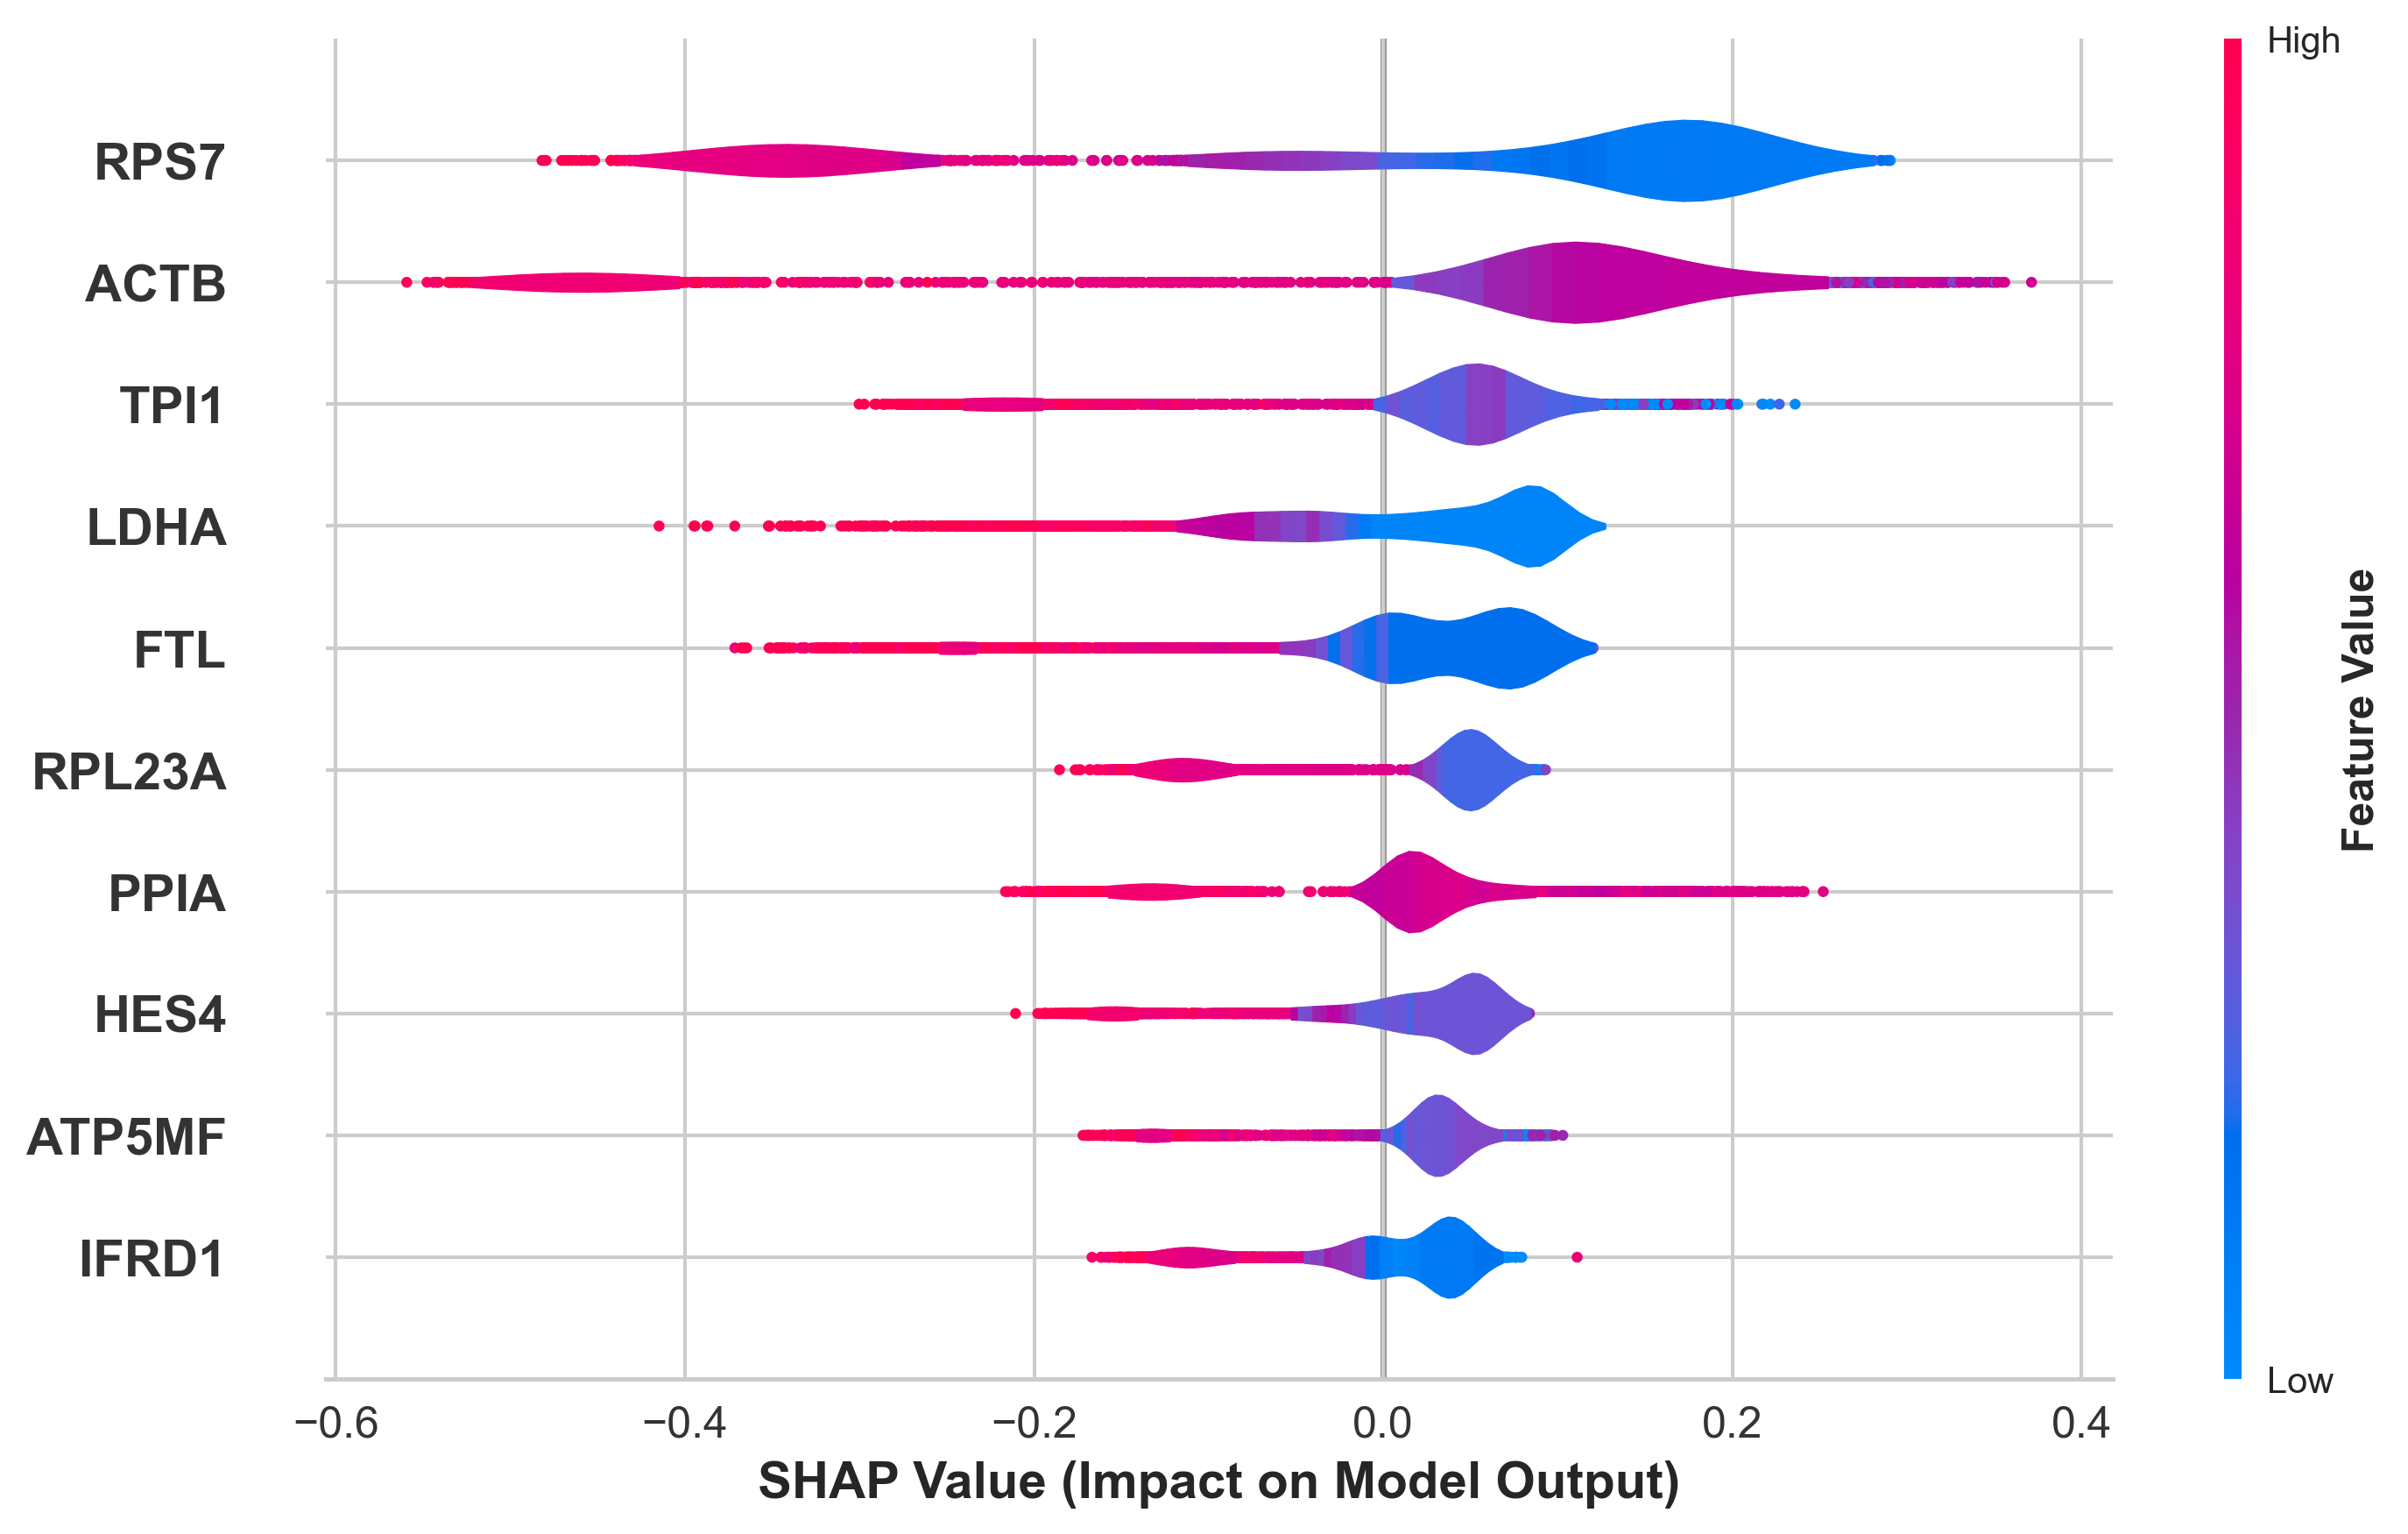

In [16]:
target_genes = ['RPS7', 'ACTB', 'FTL', 'PPIA', 'TPI1', 
                 'IFRD1', 'HES4', 'LDHA', 'ATP5MF', 'RPL23A']

pl.plot_shap_custom_features(
    shap_values=shap_values, 
    X_train=X_trans_df, 
    feature_names=feature_names, 
    target_features=target_genes, 
    plot_type="violin",
    save_path='./Plot/Figure1_Panel_D_SHAP'
)

In [3]:
import session_info

session_info.show()